In [8]:
import pandas as pd 
import yaml
import torch
from transformers import (AutoTokenizer, AutoModelForCausalLM)
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
import warnings
import itertools
from evaluation_tools import compute_metrics_crossval
from probes import LRProbe

import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [9]:
 

ds_names=["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans", "inventors",
"neg_inventors", "animal_class", "neg_animal_class", "element_symb", "neg_element_symb"]

llama_name="Llama3-8b-instruct"
mistral_name="Mistral-8b-instruct"
model_name=mistral_name

N=5


def root_paths(keyphrase,layers):

    root_path_format_1=f"data/acts/{model_name}/layer_{layers}/format1_{keyphrase}"
    root_path_format_2=f"data/acts/{model_name}/layer_{layers}/format2_{keyphrase}"
    root_path_format_3=f"data/acts/{model_name}/layer_{layers}/format3_{keyphrase}"

    original=f"data/acts/{model_name}/layer_{layers}/original"

    formats=[ root_path_format_1, root_path_format_2,root_path_format_3]

    return original, formats



In [10]:
LAYER=18


 

def get_acts_labels(formats_train, formats_test, format_number):
    acts_train_list=[]
    labels_train_list=[]
    acts_test_list=[]
    labels_test_list=[]


    for ds_name in ds_names:

        dict_format_train=torch.load(f"{formats_train[format_number]}/{ds_name}.pt")
        dict_format_test=torch.load(f"{formats_test[format_number]}/{ds_name}.pt")

        acts_train=dict_format_train["acts"]
        labels_train=dict_format_train["labels"] 

        acts_test=dict_format_test["acts"] 
        labels_test=dict_format_test["labels"] 

        acts_train_list.append(acts_train-torch.mean(acts_train, axis=0)) 

        labels_train_list.append(labels_train) 
        acts_test_list.append(acts_test-torch.mean(acts_test, axis=0)) 

        labels_test_list.append(labels_test)

    acts_train=torch.cat(acts_train_list)
    acts_test=torch.cat(acts_test_list)
    labels_train=torch.cat(labels_train_list)
    labels_test=torch.cat(labels_test_list)

    probe=LRProbe.from_data(acts_train, labels_train)

    return acts_train, labels_train, acts_test, labels_test, probe.LR

# acts_train=acts_train-torch.mean(acts_train, axis=0)
# acts_test=acts_test-torch.mean(acts_test, axis=0)



In [11]:
def PCA_generalization(ax1,ax2, acts1 , labels1, acts2, labels2, format_train, format_test, logreg_model, same_lim= False):

    """Performs PCA on acts1 and plots acts 2 on the same components"""
    

    # Step 2: Convert to NumPy
    X_np = acts1.numpy()
    labels_np = labels1.numpy()

    # Step 3: Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_np)

    # Step 4: Define colors for binary labels
    colors = ['red', 'blue']  # Red for 0, Blue for 1

    # Step 5: Plot with two colors

    label_combinations = {
        (0, 0): ('red', 'o'),     # Red, Circle
        (0, 1): ('blue', 's'),    # Blue, Square
        (1, 0): ('green', '^'),   # Green, Triangle
        (1, 1): ('magenta', 'D')   # Purple, Diamond
    }

    ax1.scatter(X_pca[:, 0], X_pca[:, 1] ,c=[colors[int(label)] for label in labels_np], s=7, alpha=0.25)
    # Step 6: Add legend and labels
    ax1.legend()
    # ax1.set_xlabel("Principal Component 1")
    ax1.grid(True)
    # ax1.set_xlim([-1,1])
    # ax1.set_ylim([-1,1])
    xlim1 = ax1.get_xlim()
    ylim1 = ax1.get_ylim()


    # Step 3: Convert tensors to NumPy
    X_np = acts2.numpy()
    labels_np = labels2.numpy()

    # Step 3: Apply PCA to reduce to 2D
    # pca = PCA(n_components=2)
    # X_pca = pca.fit_transform(X_np) 

    X_pca = pca.transform(X_np)

    # Step 4: Define colors for binary labels
    colors = ['red', 'blue']  # Red for 0, Blue for 1

    ax2.scatter(X_pca[:, 0], X_pca[:, 1],c=[colors[int(label)] for label in labels_np], s=7, alpha=0.25)

    xlim2 = ax2.get_xlim()
    ylim2 = ax2.get_ylim()

    # ax2.legend()
    ax2.grid(True)



    if logreg_model is not None:

        w = logreg_model.coef_.ravel()         
        b = logreg_model.intercept_[0]          
        mu = pca.mean_                         

        w_pca = pca.components_.dot(w)        
        b_pca = b + w.dot(mu)                  

        zz = np.linspace(xlim1[0], xlim1[1], 200)
        zz2 = -(w_pca[0] * zz + b_pca) / w_pca[1]

        # plot on both subplots
        for ax in (ax1, ax2):
            ax.plot(zz, zz2, 'k--', label="LogReg boundary")
            # ax.legend()


            # ax.set_xlim(xlim)
            # ax.set_ylim(ylim)
    ax1.set_xlim(xlim1)
    ax1.set_ylim(ylim1)
    ax2.set_xlim(xlim2)
    ax2.set_ylim(ylim2)

    if same_lim==True:


        ax2.set_xlim(xlim1)
        ax2.set_ylim(ylim1)



/var/folders/3v/bn9244294jz8331vq9x_7d440000gn/T/ipykernel_3851/2466035982.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/3v/bn9244294jz8331vq9x_7d440000gn/T/ipykernel_3851/2466035982.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/3v/bn9244294jz8331vq9x_7d440000gn/T/ipykernel_3851/2466035982.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


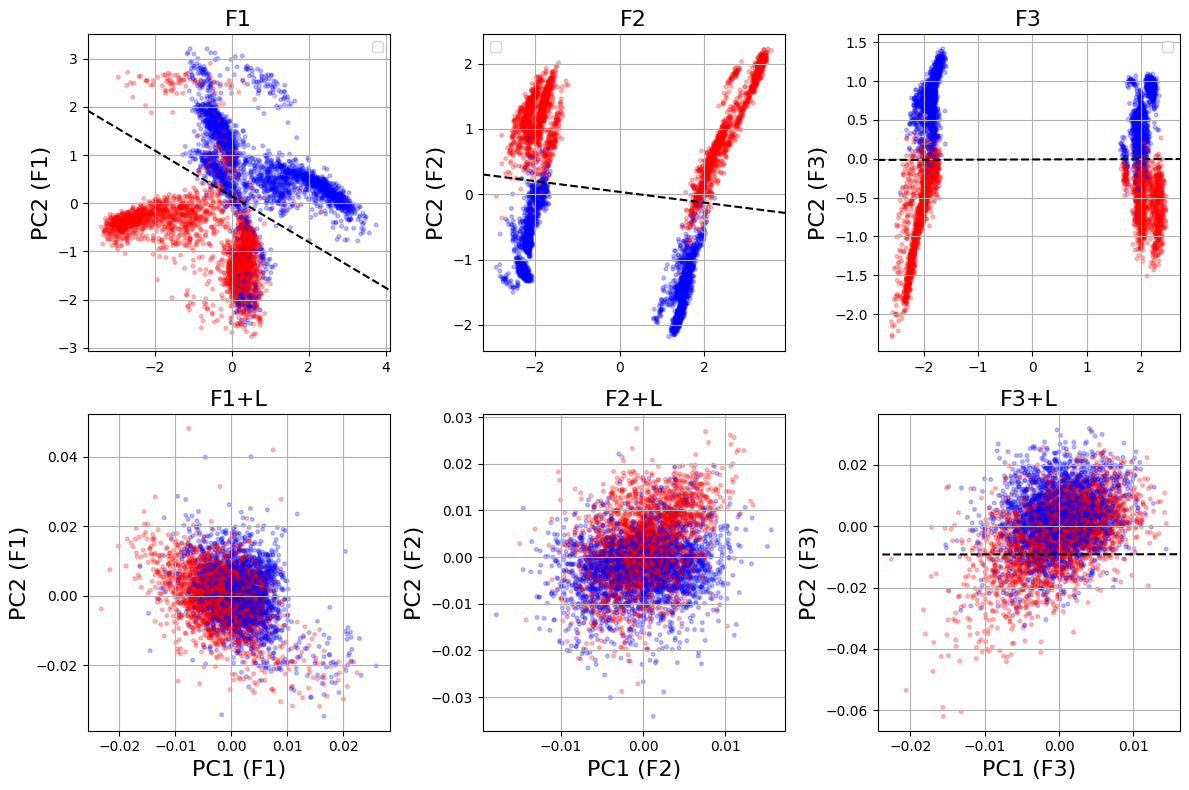

In [12]:
fig, axes= plt.subplots(2,3, figsize=(12, 8))


format_train="none"
format_test="longer"

format_train_names=["format1_short","format2_short","format3_short"]
format_test_names=["format1_long","format2_long","format3_long"]


_, formats_train=root_paths(format_train,LAYER)
_, formats_test=root_paths(format_test, LAYER)

for i in range(3):

    ax1=axes[0,i]
    ax2=axes[1,i]
    acts_train, labels_train, acts_test, labels_test, logreg_model=get_acts_labels(formats_train, formats_test, i)
    PCA_generalization(ax1,ax2, acts_train, labels_train, acts_test, labels_test, format_train=format_train_names[i], format_test=format_test_names[i],logreg_model=logreg_model, same_lim=False)

    ax1.set_title(f"F{i+1}",fontsize=16)
    ax2.set_title(f"F{i+1}+L",fontsize=16)

    ax2.set_xlabel(f"PC1 (F{i+1})",fontsize=16)
    ax1.set_ylabel(f"PC2 (F{i+1})",fontsize=16)
    ax2.set_ylabel(f"PC2 (F{i+1})",fontsize=16)


plt.tight_layout()
plt.savefig( f"figures/{model_name}/standard_pca", dpi=300)




/var/folders/3v/bn9244294jz8331vq9x_7d440000gn/T/ipykernel_3851/2466035982.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/3v/bn9244294jz8331vq9x_7d440000gn/T/ipykernel_3851/2466035982.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/3v/bn9244294jz8331vq9x_7d440000gn/T/ipykernel_3851/2466035982.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


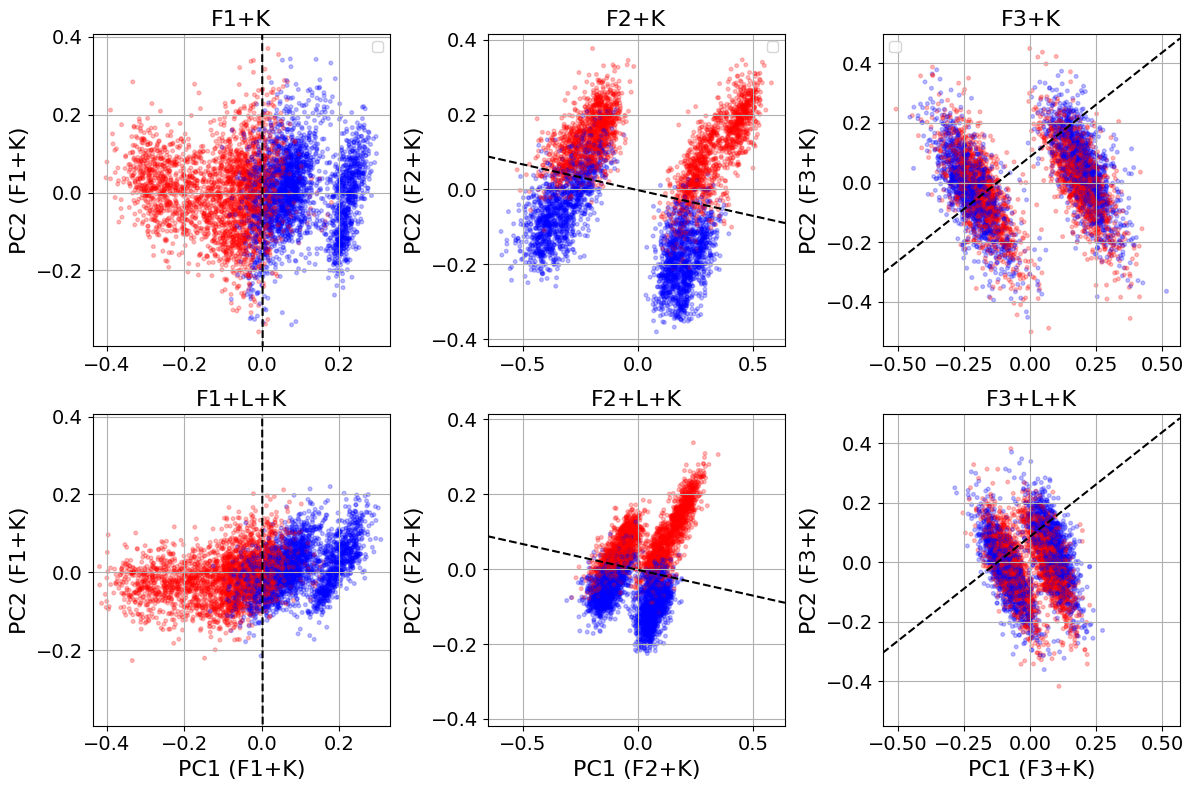

In [13]:
fig, axes= plt.subplots(2,3, figsize=(12, 8))


format_train="keyphrase"
format_test="longer_keyphrase"

format_train_names=["format1_short_kp","format2_short_kp","format3_short_kp"]
format_test_names=["format1_long_kp","format2_long_kp","format3_long_kp"]


_, formats_train=root_paths(format_train,LAYER)
_, formats_test=root_paths(format_test, LAYER)

for i in range(3):

    ax1=axes[0,i]
    ax2=axes[1,i]
    acts_train, labels_train, acts_test, labels_test,logreg_model=get_acts_labels(formats_train, formats_test, i)
    PCA_generalization(ax1,ax2, acts_train, labels_train, acts_test, labels_test, format_train=format_train_names[i], format_test=format_test_names[i],logreg_model=logreg_model, same_lim=True)

    ax1.set_title(f"F{i+1}+K",fontsize=16)
    ax2.set_title(f"F{i+1}+L+K",fontsize=16)

    ax2.set_xlabel(f"PC1 (F{i+1}+K)",fontsize=16)
    ax1.set_ylabel(f"PC2 (F{i+1}+K)",fontsize=16)
    ax2.set_ylabel(f"PC2 (F{i+1}+K)",fontsize=16)

    ax1.tick_params(axis='both', labelsize=14)  
    ax2.tick_params(axis='both', labelsize=14)   
 
plt.tight_layout()
plt.savefig( f"figures/{model_name}/keyphrase_pca", dpi=300)

In [14]:
acts_train.shape

torch.Size([5212, 4096])